In [1]:
import os
import torch
import torchvision

from network import VAECNF

import matplotlib.pyplot as plt

# Set args

In [2]:
class Args:
    seed = 1234

    data_dirpath = "./.data/"
    batch_size = 30000
    n_epochs = 43
    log_interval = 25
    eval_interval = 100
    lr_gen = 0.002

    in_out_dim = 784
    hidden_dim = 32
    latent_dim = 2
    ode_t0 = 0
    ode_t1 = 10
    cov_value = 0.1
    ode_hidden_dim = 32
    ode_width = 32
    dropout_ratio = 0.1

    recon_loss_weight = 3.0
    kl_divergence_weight = 0.1
    cnf_loss_weight = 0.1

    viz = True
    n_viz_time_steps = 11
    log_dirpath = "./logs/vae_cnf_encconddisc_final/"

    gen_checkpoint_filepath = "./logs/trial3/checkpoints/cpt_gen_4000.pth"
    disc_checkpoint_filepath = ""

    device = "cuda:0"

args = Args()

# Data

In [3]:
mnist_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
ds = torchvision.datasets.MNIST(args.data_dirpath, transform=mnist_transform, download=True)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)

# Load checkpoint

In [4]:
generator = VAECNF(
    batch_size=args.batch_size,
    in_out_dim=args.in_out_dim,
    hidden_dim=args.hidden_dim,
    latent_dim=args.latent_dim,
    ode_t0=args.ode_t0,
    ode_t1=args.ode_t1,
    cov_value=args.cov_value,
    ode_hidden_dim=args.ode_hidden_dim,
    ode_width=args.ode_width,
    dropout_ratio=args.dropout_ratio,
    device=args.device,
).to(args.device)
saved_checkpoint = torch.load(args.gen_checkpoint_filepath)
saved_state_dict = saved_checkpoint["model"]
generator.load_state_dict(saved_state_dict)

<All keys matched successfully>

# Inference

In [5]:
for batch in dl:
    generator.eval()
    image, label = batch
    image, label = image.to(args.device), label.to(args.device)
    condition = generator.condition_embedding_layer(label)
    # latent = generator.image_encoder(image, condition)
    latent, mean, std = generator.image_encoder(image, condition)
    break

label_np = label.detach().cpu().numpy()

gen_images, gen_latents, time_space = generator.generate(args.batch_size, args.n_viz_time_steps, True)

encoder_latent = latent.detach().cpu().numpy()
cnf_latent = gen_latents[:, -1, ...].detach().cpu()

# Visualization

In [6]:
def visualize_latent(latent, label, lim=5, show_legend=False, save_filepath=""):
    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
    for l in range(10):
        if show_legend:
            plt.scatter(*latent[label == l].T, color=colors[l], alpha=0.3, s=10)
            plt.legend(range(10))
        else:
            plt.scatter(*latent[label == l].T, color="maroon", alpha=0.2, s=10)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    if save_filepath:
        if not os.path.exists(os.path.split(save_filepath)[0]):
            os.makedirs(os.path.split(save_filepath)[0])
        plt.savefig(save_filepath, dpi=300, bbox_inches="tight")
    plt.show()

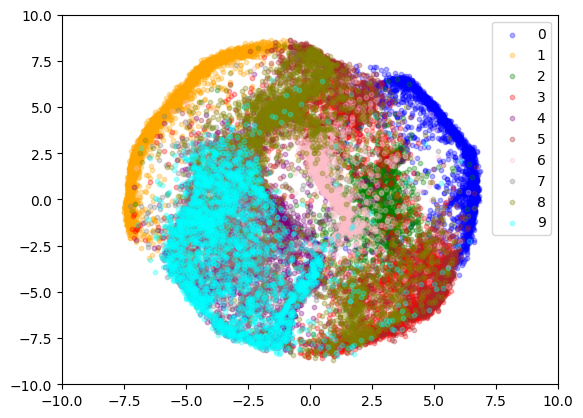

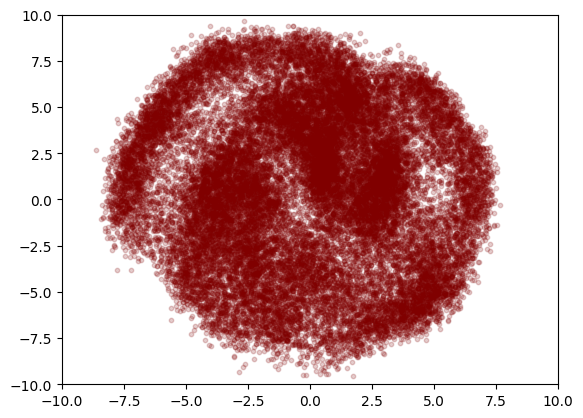

In [7]:
lim=10
visualize_latent(encoder_latent, label_np, lim=lim, show_legend=True, save_filepath="./result/encoder_latent.png")
visualize_latent(cnf_latent, label_np, lim=lim, show_legend=False, save_filepath="./result/cnf_latent.png")